## Pendulum: Two-step Method

In [1]:
import sys
#sys.path.append('/Users/josorior/Documents/UW/research/keql/KEQL/source')
#sys.path.append('/Users/yasaminjalalian/Repos/KEQL/source')
sys.path.append('/home/juanfelipe/Desktop/research/keql/source')

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import *
from data_loader import *

ValueError: could not broadcast input array from shape (0,) into shape (3,)

In [3]:
model = 'pendulum'

1. This u will be drawn from a GP and in order to generate a test set we again draw from the same GP with another bandwidth and scaled to represent a small perturbation. 
2. We still have the access to the derivatives. Check how derivatives are computed. 
3. Draw from a GP and add those value to the sine. 

### Solution: Two-Step Method

> Step 1: Learning $u's$

In [4]:
optim_sgm, alphas, optim_lmbd = kernel_parameters(x_train.reshape(-1,1),u_train)

In [5]:
optim_sgm, optim_lmbd 

(array([0.48619478, 0.62501828, 0.62501828]),
 array([1.12883789e-07, 2.06913808e-06, 2.06913808e-06]))

In [6]:
u_pred_train, u_x_pred_train, u_xx_pred_train = predictions_ode(x_train, x_train, Gaussian, optim_sgm, alphas)
#u_pred_test,  u_x_pred_test,  u_xx_pred_test  = predictions_ode(x_test,  x_train, Gaussian, optim_sgm, alphas)

In [7]:
# Save true values to warm up the onepfive method
np.save('data/u_pred_train.npy', u_pred_train)
# Save true gradients for comparing later
np.save('data/u_x_train.npy',u_x_train)
np.save('data/u_xx_train.npy',u_xx_train)
# Save gradients for one step method
np.save('data/u_x_pred_train.npy',u_x_pred_train)
np.save('data/u_xx_pred_train.npy',u_xx_pred_train)

Normalized MSE :  = 1.8807326643964553e-08
Normalized MSE :  = 2.7174632591781616e-06
Normalized MSE :  = 0.00015356704914434247
Normalized MSE :  = 1.8787833467128338e-07
Normalized MSE :  = 0.0004983118838526309
Normalized MSE :  = 0.04075395629117341
Normalized MSE :  = 6.621192492175087e-08
Normalized MSE :  = 0.00023003215250581266
Normalized MSE :  = 0.1086831010674958


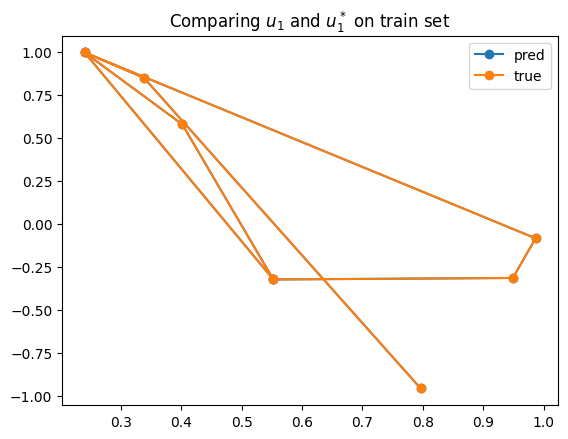

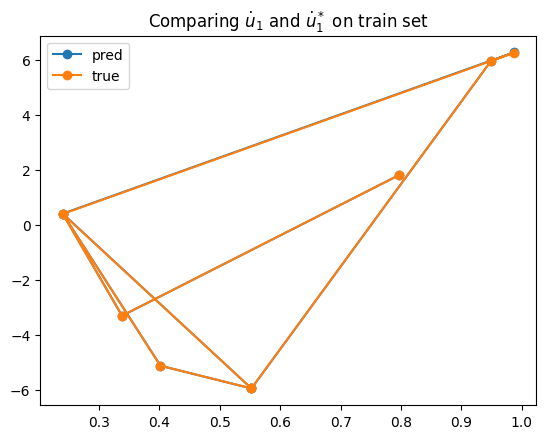

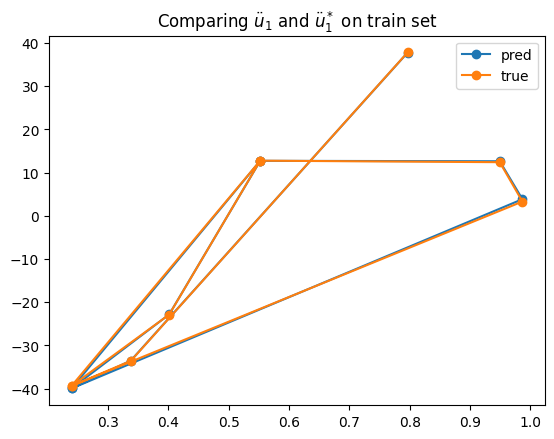

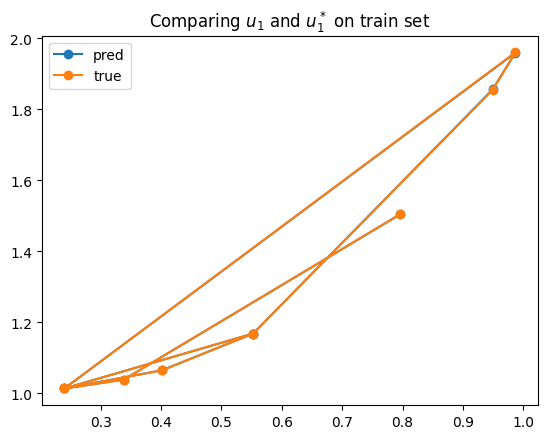

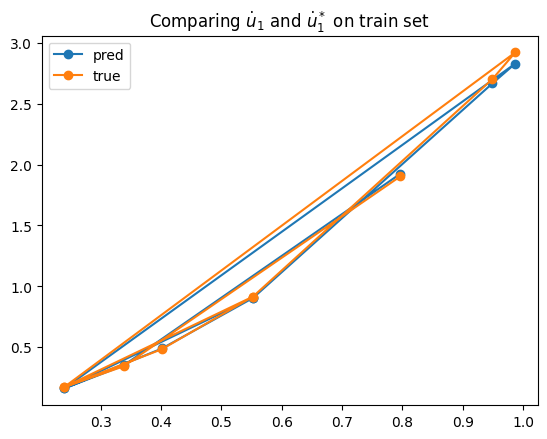

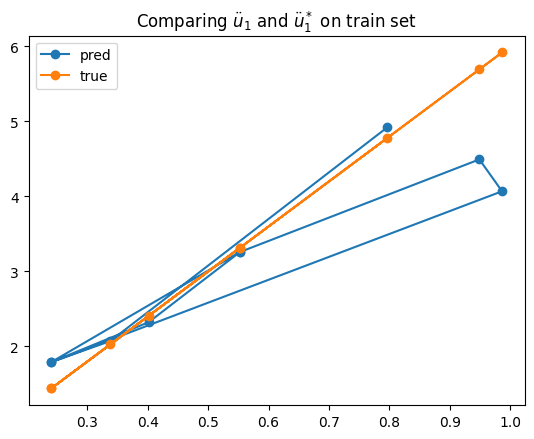

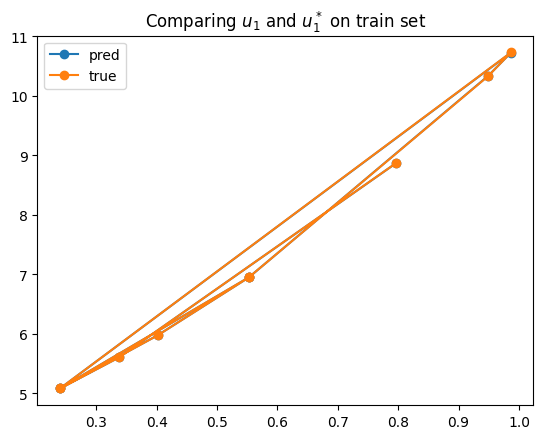

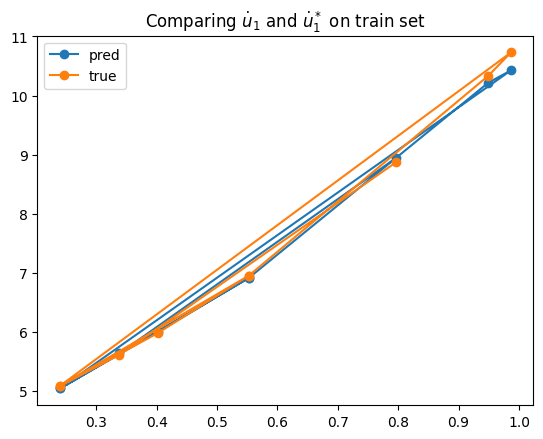

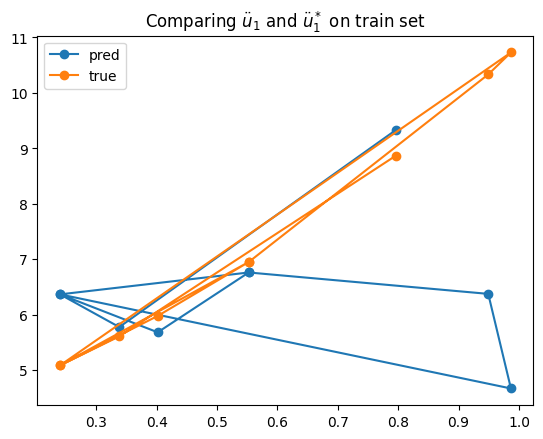

In [8]:
for i in range(3):
    mse_ui    = mse_plot(x_train, u_train[:,i],    u_pred_train[:,i],    title = 'Comparing $u_1$ and $u_1^*$ on train set')
    mse_ui_x  = mse_plot(x_train, u_x_train[:,i],  u_x_pred_train[:,i],  title = 'Comparing $\dot u_1$ and $\dot u_1^*$ on train set')
    mse_ui_xx = mse_plot(x_train, u_xx_train[:,i], u_xx_pred_train[:,i], title = 'Comparing $\ddot u_1$ and $\ddot u_1^*$ on train set')
plt.show()

> Step 2: Learning $P$

In [9]:
s_train = np.hstack((x_train_all.reshape(-1,1),u_pred_train.T.reshape(-1,1),u_x_pred_train.T.reshape(-1,1),u_xx_pred_train.T.reshape(-1,1)))  # 300 * 4
f_train = f_Train(model)
scaler_s_train = MinMaxScaler()
s_train_s = scaler_s_train.fit_transform(s_train)

ValueError: could not broadcast input array from shape (9,) into shape (10,)

In [ ]:
optim_sgm_P, optim_lmbd_P = grid_search_RBF(s_train_s,f_train)
krr_optimal_P = KernelRidge(kernel='rbf', alpha = optim_lmbd_P, gamma=1/(2*(optim_sgm_P**2))) 
krr_optimal_P.fit(s_train_s, f_train) 
f_pred_train = krr_optimal_P.predict(s_train_s) 

In [ ]:
optim_sgm_P, optim_lmbd_P

(1.3449937764411533, 0.0006951927961775591)

In [ ]:
import numpy as np
p = 0.4
M1 = np.array([np.random.binomial(1,p) for i in range(10)])

In [ ]:
M1

array([0, 1, 1, 0, 1, 0, 1, 0, 0, 1])

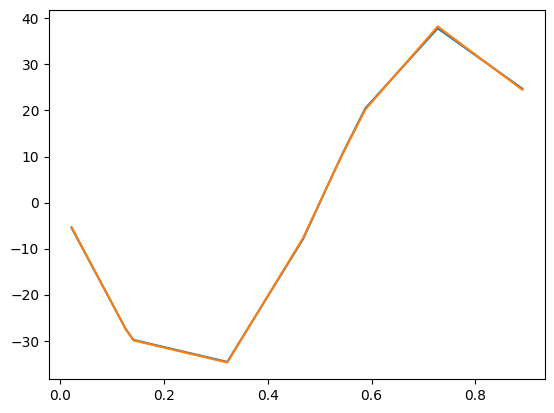

In [ ]:
plt.plot(x_train,f_pred_train[:N])
plt.plot(x_train,f_train[:N])
plt.show()

**Testing**: We recreate three scenarios. All of them are passing the sanity check that if we add noise 0 we should get a small mse. 

Also, we have two types of experiments:
1. we add the noise and then rescale the perturbed data
2. we just apply noise directly to the scaled data

>Test 1: Add arbitrary noise to observations.

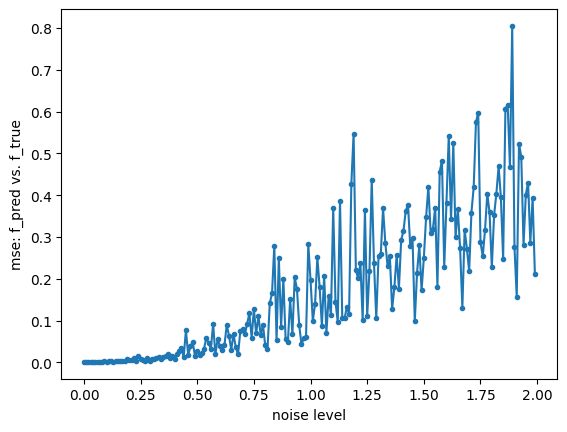

In [ ]:
scales = np.arange(0.0,2,0.01)   
mses_P = [] 
for scale in scales:
    # Perturb 
    s_test = np.random.normal(s_train,scale=scale)
    # Scale 
    s_test_s = scaler_s_train.transform(s_test)
    # Compute predictions on test
    f_pred_test = krr_optimal_P.predict(s_test_s)
    # True test -> Why if I use this rule for s_test_s the bellow rule cannot be compared with f_pred_test
    f_true_test = f_true_Test(model, s_test)
    # Compute mse per scale 
    mses_P.append(mean_squared_error(f_true_test,f_pred_test)/mean_squared_error(0*f_true_test,f_true_test))
# Plot 
plt.plot(scales,mses_P,'.-')
plt.xlabel('noise level')
plt.ylabel('mse: f_pred vs. f_true')
plt.show()

In [ ]:
# Perturb 
s_test = np.random.normal(s_train,scale=0.0)
# Scale 
s_test_s = scaler_s_train.transform(s_test)
# Compute predictions on test
f_pred_test = krr_optimal_P.predict(s_test_s)
# True test -> Why if I use this rule for s_test_s the bellow rule cannot be compared with f_pred_test
f_true_test = f_true_Test(model, s_test)

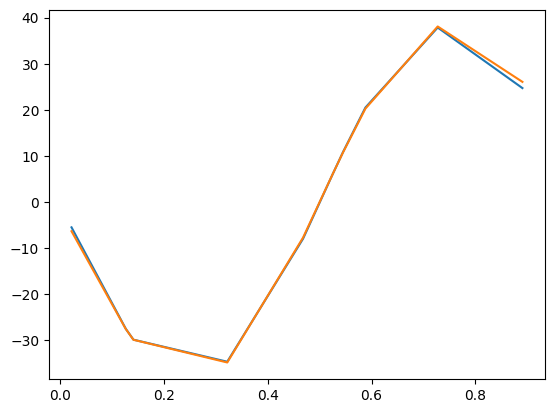

In [ ]:
plt.plot(x_train,f_pred_test[0:N])
plt.plot(x_train,f_true_test[0:N])

> Test 2: Compute global std $\sigma_{\text{global}}$ of `s_train_s` and perturb directly `s_train_s` using $m \sigma_{\text{global}}$ each element. $m \in (0.00,0.25)$.

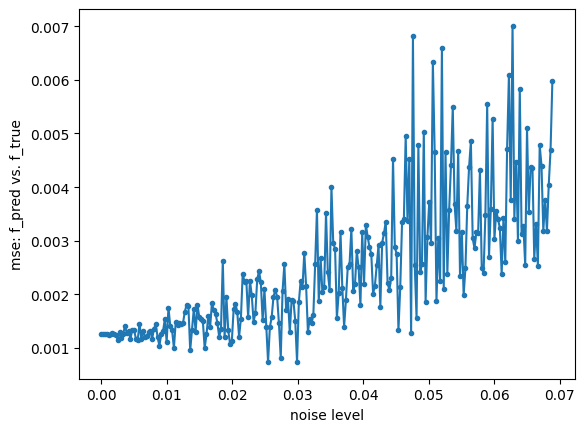

In [ ]:
# Compute global std of s_train_s
global_std = np.std(s_train_s)

scales = np.arange(0.0,0.25,0.001)*global_std   
mses_P = [] 
for scale in scales:
    # Perturb scaled training data
    s_test_s = np.random.normal(s_train_s,scale=scale)
    # Compute predictions on test
    f_pred_test = krr_optimal_P.predict(s_test_s)
    # True test -> Why if I use this rule for s_test_s the bellow rule cannot be compared with f_pred_test
    s_test = scaler_s_train.inverse_transform(s_test_s)
    f_true_test = f_true_Test(model, s_test)
    # Compute mse per scale 
    mses_P.append(mean_squared_error(f_true_test,f_pred_test)/mean_squared_error(0*f_true_test,f_true_test))
# Plot 
plt.plot(scales,mses_P,'.-')
plt.xlabel('noise level')
plt.ylabel('mse: f_pred vs. f_true')
plt.show()

> Test 3: Compute std per feature i $\sigma_{\text{s[:,i]}}$ of `s_train_s` and perturb feature i of `s_train_s` using $m \sigma_{\text{s[:,i]}}$ each element. $m \in (0.01,0.25)$.

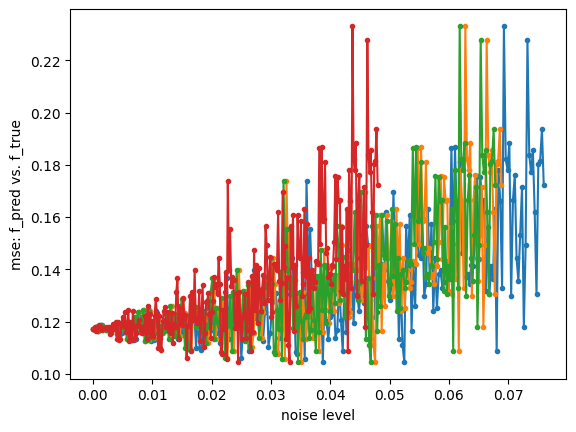

In [ ]:
# Compute std per feature of s_train_s
stds = np.std(s_train_s, axis = 0)

scales = np.outer(np.arange(0.0,0.25,0.001),stds)
mses_P = [] 
for i in range(len(scales)):
    # Scales for current iteration
    scale = scales[i,:]
    # Perturb each feature
    for j in range(4):
        s_test_s[:,j] = np.random.normal(s_train_s[:,j] , scale = scale[j])
    # Compute predictions on test
    f_pred_test = krr_optimal_P.predict(s_test_s)
    # True test -> Why if I use this rule for s_test_s the bellow rule cannot be compared with f_pred_test
    f_true_test = f_true_Test(model, s_test)
    # Compute mse per scale 
    mses_P.append(mean_squared_error(f_true_test,f_pred_test)/mean_squared_error(0*f_true_test,f_true_test))
# Plot - We have a vector of dimension 4 of scales vs. mses
plt.plot(scales,mses_P,'.-')
plt.xlabel('noise level')
plt.ylabel('mse: f_pred vs. f_true')
plt.show()